# Evaluating portfolio diversification using Principle Component Analysis

The closing prices of a basket of assets is considered over a period of days. To compare how the set of prices on each day compare with other days, the multivariate data could be graphed on a p-dimensional plane for a basket of size p. 

An alternative approach that is more visually appealing and requires less processing power is to produce the Principle Component Plots, which is a low-dimensional graphical representation of the data. This tool is derived from the dimensionality reduction technique of Principle Component Analysis, which projects the p-dimensional data onto a d-plane for $d \le p$. The goal is to compute the projection $Y=v^Tx_i$ that captures the largest amount of variation in the data observations ${x_1, ..., x_n}$ and therefore represents the data more closely. This approach and by implication the principle component plots help to:
1. gauge the euclidean distance between different observations;
2. identify clusters in the data; 
3. establish the level of difficulty of a classification problem. 

Therefore, the 1-d projections (linear projections) $v \in \mathbb{R}^p $ that maximise the variance of $v^Tx_i$ with $|v|=1$ help to enhance understanding of the data X, where X gives the basket returns for each each time point. Note that this project uses the fortnightly changes in prices as opposed to daily closing price volatility to provide a more stable output that is less sensitive to non-fundamental factors such as investor speculation.

More specifically, The first principal component (PC) loading $v_1$ is a choice of $v \in \mathbb{R}^p$ with $|v| = 1$ such that $Var(v_1^TX) \ge Var(u^TX)$, $\forall u ∈ R^p, |u| = 1$. For $k = 2, . . . , p$, the k-th principal component (PC) loading $v_k$ is a choice of $v \in R^p, |v| = 1$, that maximises $Var(v^TX)$ subject to $Cov(v^TX, v_j^TX) = 0$, $ \forall j =1,...,k−1$. The random variable $Y_k = v_k^TX \in \mathbb{R}$ is called the k-th principal component (PC) score.

Suppose that $\Sigma = Cov(X)$ for the $n \times p$ data matrix X, with eigenvalues $\lambda _1 \ge ... \ge \lambda _p \ge 0$. It can be shown using the Spectral Decomposition Theorem then that the PC Loadings for X are given by the corresponding unit eigenvectors $e_1, ..., e_p$, and the variances of the PC Scores $Y_1, ..., Y_n$ are given by $Var(Y_1) = \lambda _1, ..., Var(Y_p) = \lambda _p$. The three main steps are therefore engineering the data observation matrix, finding the covariance matrix and then its eigen-decomposition.

The data engineering process of X has a minimum of one and a maximum of two steps. The mandatory step is to centre the columns of X, i.e. to add a constant to each column to ensure that it has got mean 0. If $H = \frac{I_n − 11^T}{n}$, then HX is a column-centered version of X. The optional step is to standardise each column (variable) so that it has got a variance of 1, and this is done by dividing each entry in that column by the column's standard deviation. For instance, the values in the centered column i are given by $Z_{ij} = \frac{X_{ij}}{\sigma_{ijj}}$. So $\forall i \in \{1, ..., p\}, Cov(Z_i) = Corr(X_i)$. The two steps combined standardise all the columns to have mean 0 and standard devation 1. This simplifies interpretation of PC scores when the different characteristics (columns) are measured in different units/represent different types of quantites. Define $S = \frac{Z^THZ}{(n − 1)}$, the sample covariance matrix of Z, which is the standardised version of $X = (x_1, . . . , x_n)^T$.

Whilst the column-centering step is universal, standardising is not recommended in cases where the unit used is categorical (e.g. dollars) and all the columns employ this unit. Not standardising in this case enables the variance of HX to find the difference between two groups.


In [1]:
from datetime import date, timedelta

import pandas as pd
import numpy as np
import yfinance as yf
from numpy.linalg import eig
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/Users/sadiq/Documents/Learn/Tech/Projects/PCA-and-Clustering-in-Finance-Demo/env/lib/python3.12/site-packages') 
print(sys.path)

['/Users/sadiq/Documents/Learn/Tech/Projects/PCA-and-Clustering-in-Finance-Demo', '/usr/local/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/usr/local/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/usr/local/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/sadiq/Library/Python/3.11/lib/python/site-packages', '/usr/local/lib/python3.11/site-packages', '/Users/sadiq/Documents/Learn/Tech/Projects/PCA-and-Clustering-in-Finance-Demo/env/lib/python3.12/site-packages']


In [194]:
class Portfolio:

    def __init__(self, assets_list, past_prices=None, returns=None, pc_variances=None, pc_loadings=None):
        self.assets_list = assets_list
        self.past_prices = past_prices

    def retrieve_past_prices(self, number_of_days=365):
        closing_lists = []
        for asset in self.assets_list:
            assigned = yf.download(asset, start=str(date.today()- timedelta(days=number_of_days)), end=str(date.today()), auto_adjust=True)[['Close']].copy()
            assigned.rename(columns={'Close': asset}, inplace=True)
            closing_lists.append(assigned)
            result = closing_lists[0].copy()
        for i in range(1, len(closing_lists)):
            result = result.join(closing_lists[i], how='inner')
        self.past_prices = result
        return self
    
    def calculate_returns(self, number_of_days=365, periods=30):
        self.retrieve_past_prices(number_of_days)
        # self.past_prices = self.past_prices/self.past_prices.std().dropna()
        self.returns = self.past_prices.diff(periods).dropna()
        return self

    def calculate_pca(self, number_of_days=365, periods=30):
        self.calculate_returns(number_of_days)
        X = self.returns
        n = self.returns.shape[0]
        H = np.identity(n) - (np.ones((n, n))/n)
        S = ((X.transpose().reset_index(drop=True) @ H) @ X.reset_index(drop=True))/(n-1)
        w,v=eig(S)
        self.pc_variances = w
        self.pc_loadings = pd.DataFrame(data={'Feature_Names': self.assets_list, 'PC1': v[0], 'PC2': v[1]})
        return self

    def plot_variances(self, number_of_days=365, periods=30):
        self.calculate_pca(number_of_days, periods)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
        fig.suptitle('Eigenvalues, Scree Plot, and Cumulative Proportion of Variance Plot')
        ax1.plot(range(1,12), self.pc_variances)
        ax2.plot(range(1,12), 100*self.pc_variances/(sum(self.pc_variances)))
        ax3.plot(np.cumsum(self.pc_variances)/sum(self.pc_variances))

    def plot_loadings(self, number_of_days=365, periods=30):
        self.calculate_pca(number_of_days, periods)
        t = self.pc_loadings
        for i, varnames in enumerate(self.pc_loadings['Feature_Names']):
            plt.scatter(t.iloc[i, 1], t.iloc[i, 2], s=30)
            plt.text(t.iloc[i, 1], t.iloc[i, 2], varnames)

        # Define the axes
        plt.xticks(np.linspace(-0.8, 0.8, num=5))
        plt.yticks(np.linspace(-0.8, 0.8, num=5))
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        
        # Show plot
        plt.title('2D Loading plot')
        plt.show()
                

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


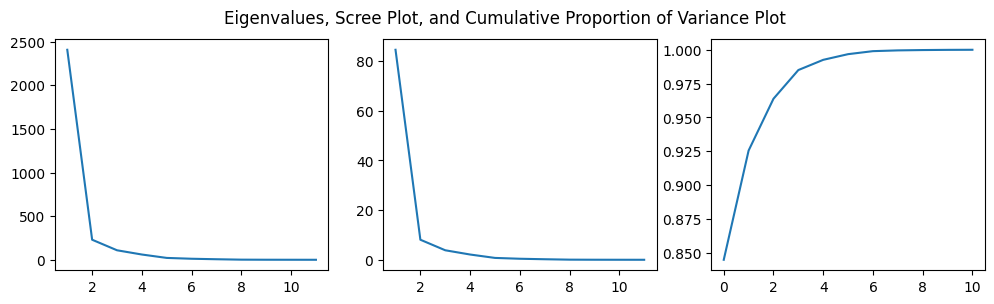

In [195]:
portfolio1 = Portfolio(['AAPL', 'NVDA', 'MSFT', 'GOLD', 'GOOG', 'AMZN', '2222.SR', 'SLV', 'META', 'BTC', 'PLAT'])
portfolio1.plot_variances(number_of_days=720, periods=30)

In [196]:
portfolio1.past_prices.tail(10)

,AAPL,NVDA,MSFT,GOLD,GOOG,AMZN,2222.SR,SLV,META,BTC,PLAT
Date,,,,,,,,,,,
2023-10-12,179.998108,46.934814,329.285278,14.862072,140.130524,132.330002,33.185852,19.959999,323.495239,87.804733,31.713200
2023-10-16,178.015945,46.085003,330.756897,15.519773,140.330322,132.550003,32.890430,20.680000,320.491394,87.799713,31.761999
2023-10-17,176.452118,43.928467,330.180145,16.118574,140.829742,131.470001,32.939663,20.920000,323.335541,87.351578,31.763901
2023-10-18,175.147293,42.186848,328.241211,16.236372,139.121689,128.130005,32.890430,20.950001,316.319977,87.158638,31.121300
2023-10-19,174.768784,42.091869,329.444336,16.305086,138.822021,128.399994,32.988903,21.110001,312.168518,87.095993,30.971701
2023-10-23,172.318481,42.965679,327.455658,16.246189,137.743256,126.559998,32.742718,21.049999,313.366058,87.540092,30.492901
2023-10-24,172.756744,43.653526,328.658844,16.256004,139.960724,128.559998,32.693478,21.020000,311.909058,87.594849,30.492901
2023-10-25,170.425964,41.769932,338.741455,16.275637,126.526016,121.389999,32.545765,20.940001,298.915771,87.297417,30.492901
2023-10-26,166.232529,40.317253,326.033783,16.000776,123.299690,119.570000,32.693478,20.850000,287.758667,87.631691,30.492901


Using the 90% Cumulative Variance Techniques, the first two PC Loadings explain more than 90% of the variance in the data. For this reason, two PCs are selected to give the model both parsimony and plausibility. The scree plot also indicates that a selection of one or two PCs (before the shoulder) is suitable for this data. 

Using the most recent closing price data, the 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


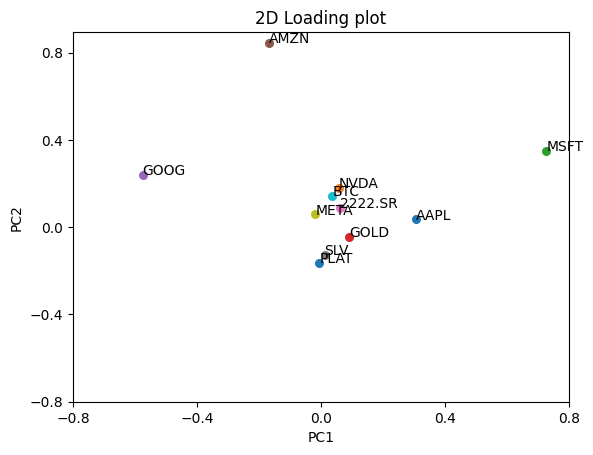

In [197]:
portfolio1.plot_loadings()

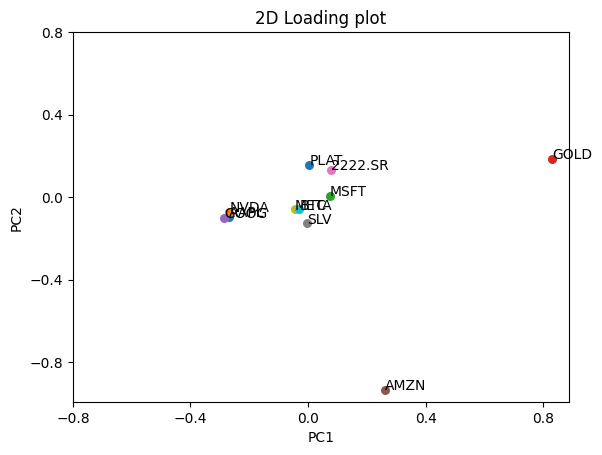

In [189]:
t = pd.DataFrame(data={'Feature_Names': df.columns, 'PC1': v[0], 'PC2': v[1]})
for i, varnames in enumerate(t['Feature_Names']):
    plt.scatter(t.iloc[i, 1], t.iloc[i, 2], s=30)
    plt.text(t.iloc[i, 1], t.iloc[i, 2], varnames)

# Define the axes
plt.xticks(np.linspace(-0.8, 0.8, num=5))
plt.yticks(np.linspace(-0.8, 0.8, num=5))
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('2D Loading plot')
plt.show()

Their project values on each PC show how much weight they have on that PC. In this example, NPC2 and CHIT1 strongly influence PC1, while GBA and LCAT have more say in PC2.
Another nice thing about loading plots: the angles between the vectors tell us how characteristics correlate with one another. Let’s look at Figure 2.
When two vectors are close, forming a small angle, the two variables they represent are positively correlated. Example: APOD and PSAP
If they meet each other at 90°, they are not likely to be correlated. Example: NPC2 and GBA.
When they diverge and form a large angle (close to 180°), they are negative correlated. Example: NPC2 and MAG.

In [145]:
df.head(1)

,AAPL,NVDA,MSFT,GOLD,GOOG,AMZN,2222.SR,SLV,META,BTC,PLAT
Date,,,,,,,,,,,
2022-07-14,146.809036,15.354707,249.694229,14.856397,111.313332,110.629997,31.134556,17.0,157.725891,89.270264,27.108601


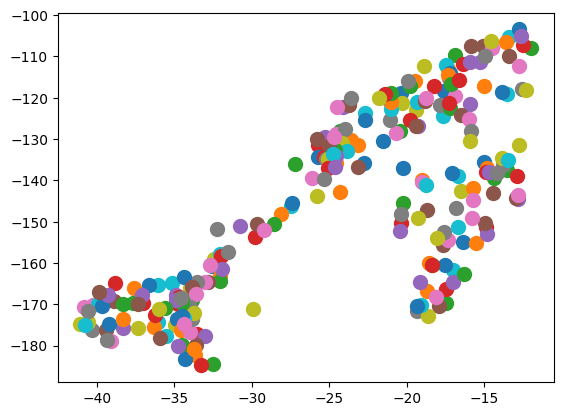

In [156]:
for i, date_ in enumerate(df.index):
    x = sum(t.PC1 * df.iloc[i].values)
    y = sum(t.PC2 * df.iloc[i].values)
    plt.scatter(x, y, s=100)

References

* https://bioturing.medium.com/how-to-read-pca-biplots-and-scree-plots-186246aae063
* https://darrensmith-16893.medium.com/using-pca-and-clustering-to-explain-market-developments-2c36a1865e03
* https://www.jcchouinard.com/python-pca-biplots-machine-learning/

In [ ]:
change = df.diff(periods=30).dropna()
# change = change/change.std().dropna()
X = change.copy()
n = X.shape[0]
H = np.identity(n) - (np.ones((n, n))/n)
S = ((X.transpose().reset_index(drop=True) @ H) @ X.reset_index(drop=True))/(n-1)
PCA_components = S.shape[0]
w,v=eig(S)
w